In [2]:
from statsmodels.regression.linear_model import OLSResults
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr
import pickle
import subprocess

In [3]:
results = OLSResults.load("regression_results/ols_trained_model.pkl")

In [4]:
sns.set_context('notebook',font_scale=1.5)

In [5]:
parameters = pickle.load(open('regression_results/parameters.pkl','rb'))

In [6]:
trainX=np.load('regression_results/trainX.npy')
trainY=np.load('regression_results/trainY.npy')
testX=np.load('regression_results/testX.npy')
testY=np.load('regression_results/testY.npy')

In [7]:
def plot_contour(x,y,title,r,p):
    sns.jointplot(x,y,kind='hex').set_axis_labels("Predicted Dpn Ratio", "Actual Dpn Ratio")

In [8]:
print('Training N =',trainX.shape[0],'Testing N =',testX.shape[0])

Training N = 34528 Testing N = 7280


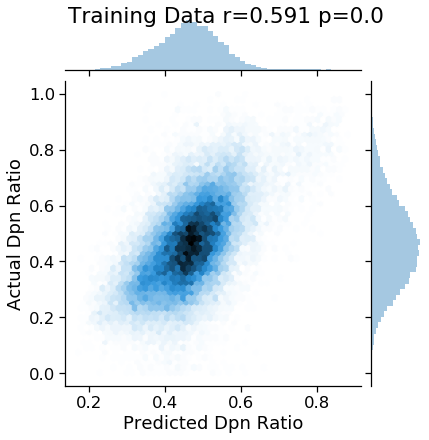

In [9]:
pred=results.predict(exog=trainX)
r = pearsonr(pred,trainY)
ro = spearmanr(pred,trainY)
plot_contour(pred,trainY,'',r[0],r[1])
plt.suptitle('Training Data r='+str(round(r[0],3))+' p='+str(round(r[1],3)))
    
plt.savefig('plots/training_data_predicted_true.svg')

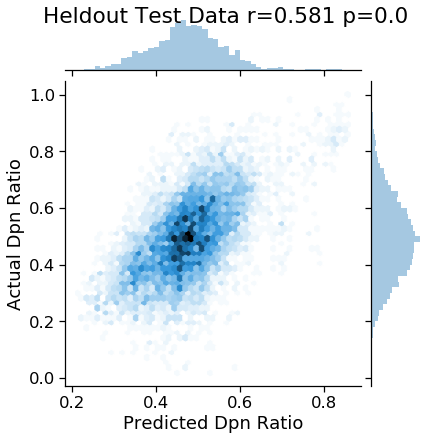

In [10]:
pred=results.predict(exog=testX)
r = pearsonr(pred,testY)
ro = spearmanr(pred,testY)
plot_contour(pred,testY,'',r[0],r[1])

plt.suptitle('Heldout Test Data r='+str(round(r[0],3))+' p='+str(round(r[1],3)))
    
plt.savefig('plots/testing_data_predicted_true.svg')

In [11]:
replicates = parameters['replicates']
kmers=parameters['kmers']
conditions=parameters['conditions']

In [12]:
conditions2clean = {'es':'ESC','ed':'DE',
                    'brachyury':'ESC Brachyury+',
                    'foxa2':'ESC FoxA2+'}
condition_names = [conditions2clean[c] for c in conditions]

/data/cgs/jhammelm/env/miniconda3/envs/jupyter-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


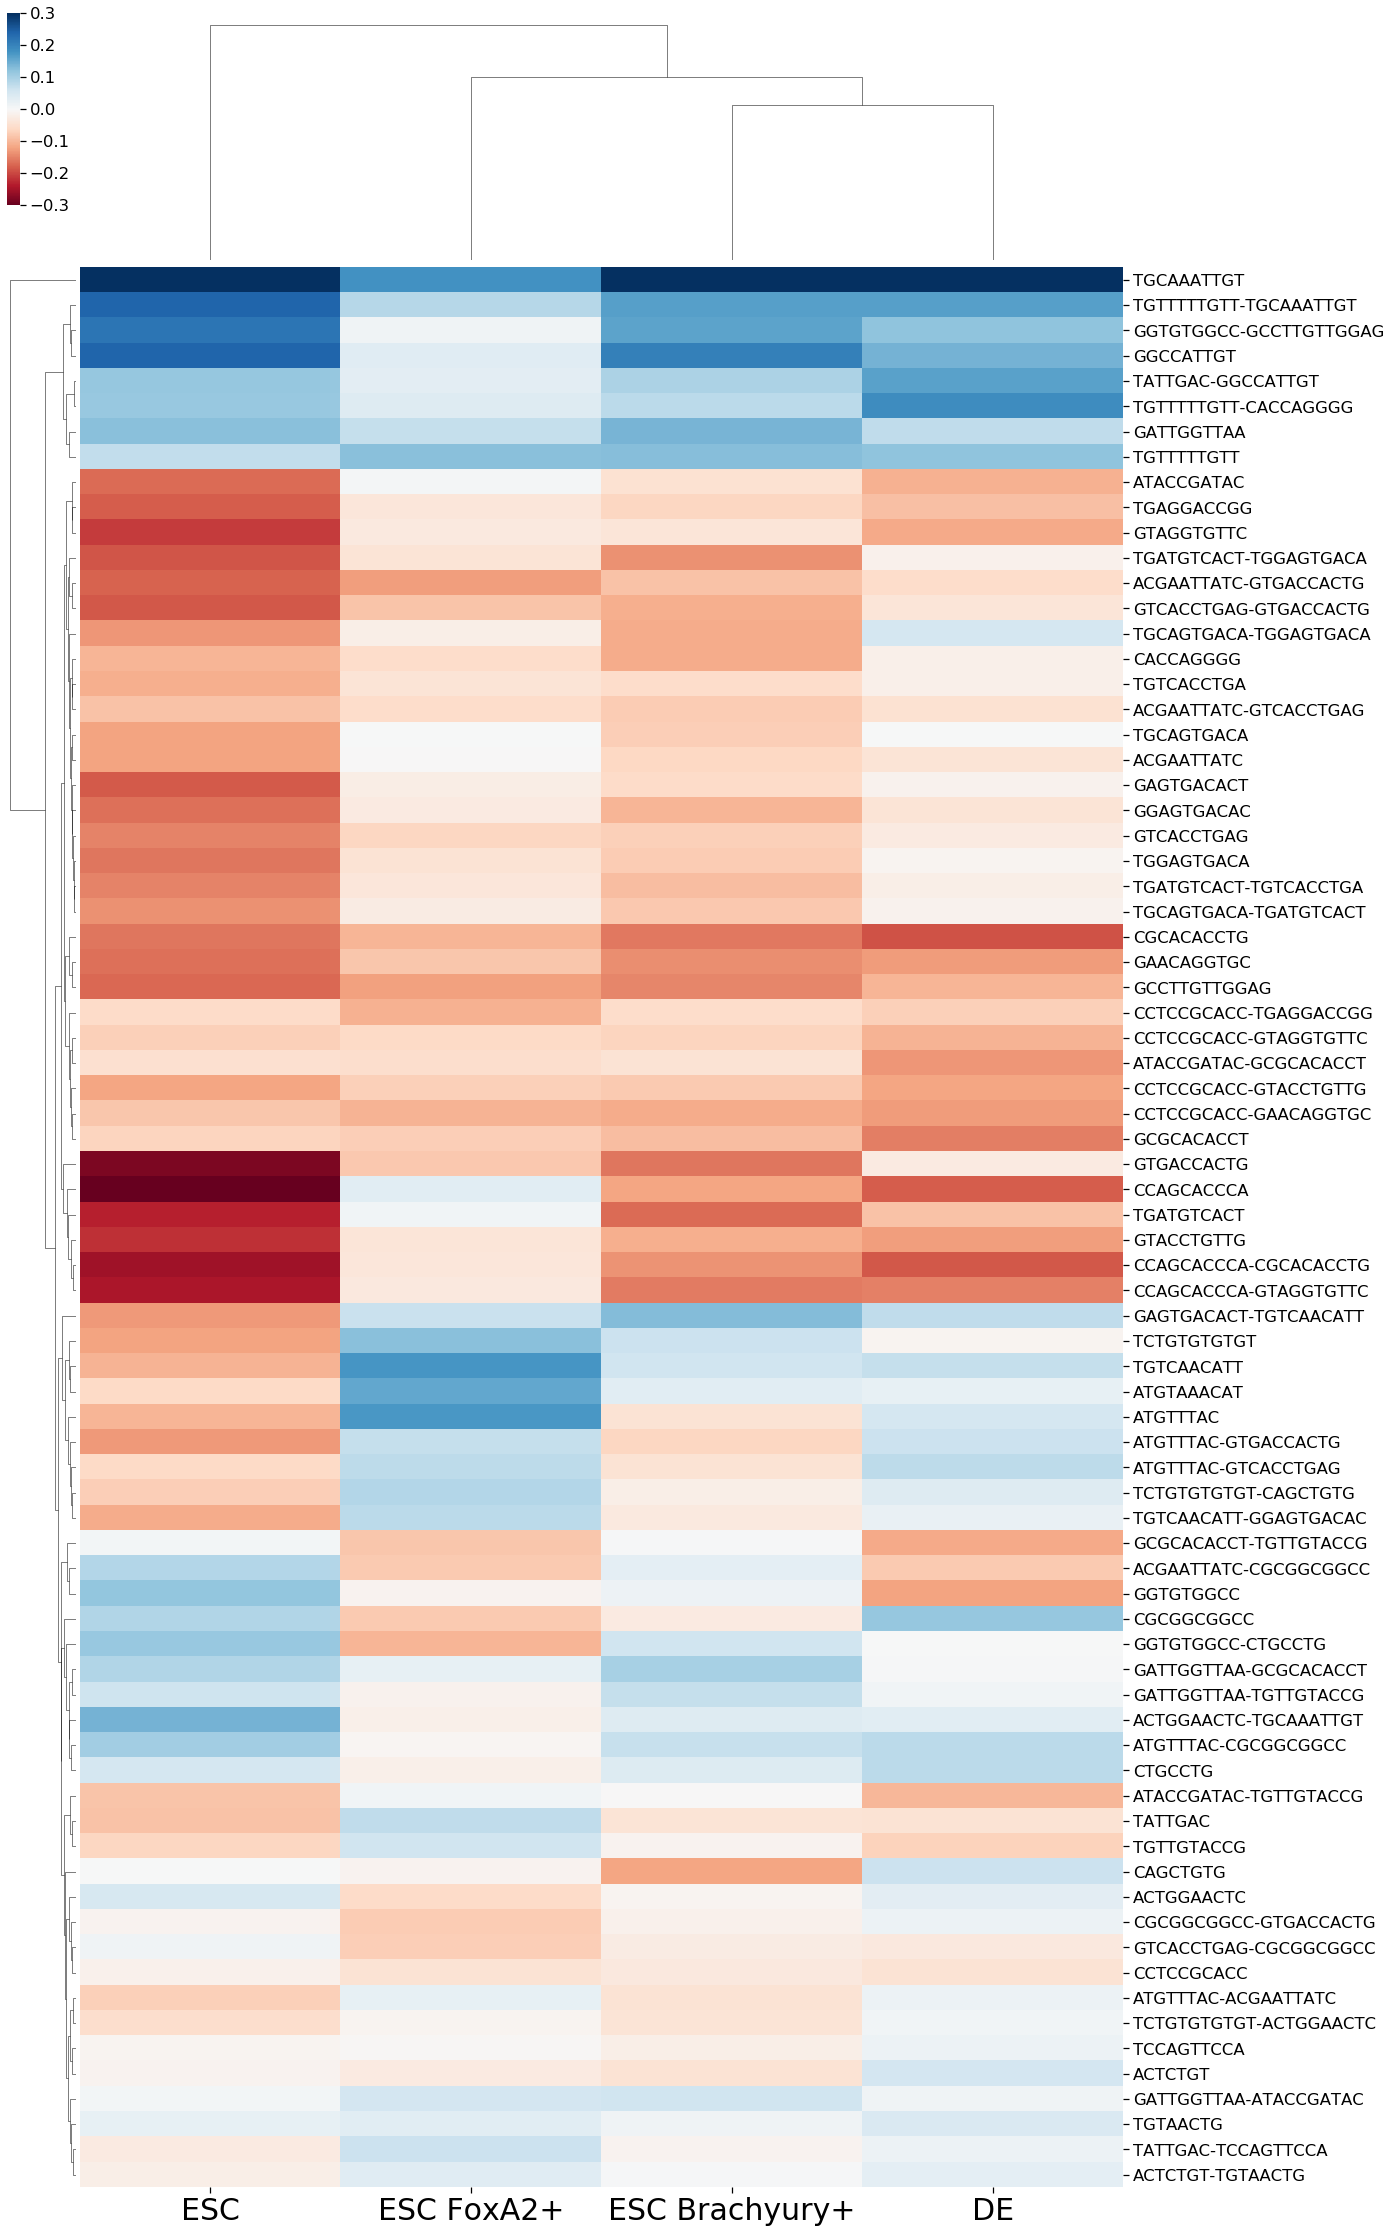

In [13]:
param_values = results.params
param_kmers_values = param_values[len(replicates):]
cmap = {'es':'blue','brachyury':'purple','foxa2':'aqua','ed':'red'}
big_mat = np.zeros((len(kmers),len(conditions)))

for j,condition in enumerate(conditions):
    big_mat[:,j] = param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]
big_df = pd.DataFrame(data=big_mat,columns=condition_names,index=kmers)
g = sns.clustermap(big_df,cmap='RdBu',figsize=(20,40),vmin=-0.3, vmax=0.3)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 30)
plt.tight_layout()
plt.savefig('plots/all_heatmap_condition_kmers.svg')

In [14]:
condition_order=['ESC','ESC FoxA2+','ESC Brachyury+','DE']

CCAGCACCCA
TGTCAACATT
ATGTTTAC
TCTGTGTGTGT
TGATGTCACT
ATGTAAACAT
ATGTTTAC-GTGACCACTG
GAGTGACACT-TGTCAACATT
TGTCAACATT-GGAGTGACAC
ATACCGATAC


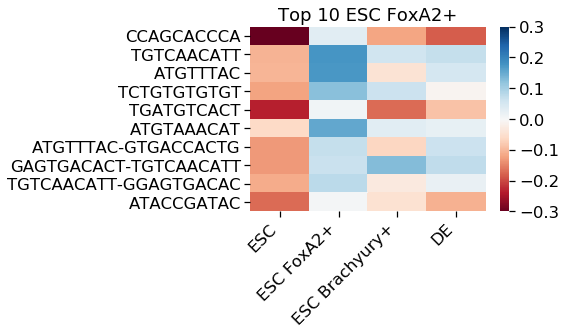

GAGTGACACT-TGTCAACATT
TCTGTGTGTGT
TGTCAACATT
ATGTAAACAT
TGTTTTTGTT
GATTGGTTAA-ATACCGATAC
ACTCTGT-TGTAACTG
GATTGGTTAA
GATTGGTTAA-TGTTGTACCG
GATTGGTTAA-GCGCACACCT


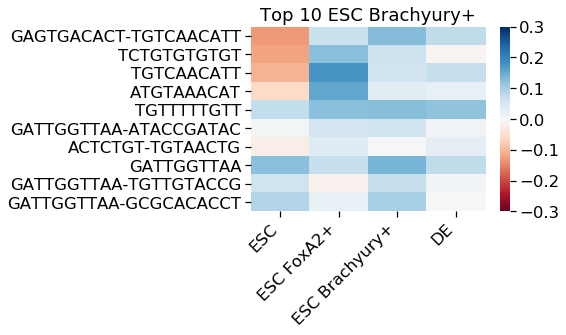

GAGTGACACT-TGTCAACATT
ATGTTTAC-GTGACCACTG
TGCAGTGACA-TGGAGTGACA
TGTCAACATT
ATGTTTAC
ATGTTTAC-GTCACCTGAG
TGTCAACATT-GGAGTGACAC
TGCAGTGACA
TCTGTGTGTGT-CAGCTGTG
ATGTTTAC-ACGAATTATC


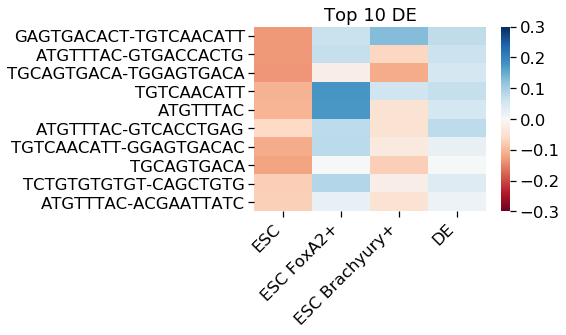

GGTGTGGCC
ACGAATTATC-CGCGGCGGCC
GCGCACACCT-TGTTGTACCG
GGTGTGGCC-CTGCCTG
ACTGGAACTC-TGCAAATTGT
GGCCATTGT
GGTGTGGCC-GCCTTGTTGGAG
GATTGGTTAA-GCGCACACCT
TGTTTTTGTT-TGCAAATTGT
GATTGGTTAA-TGTTGTACCG


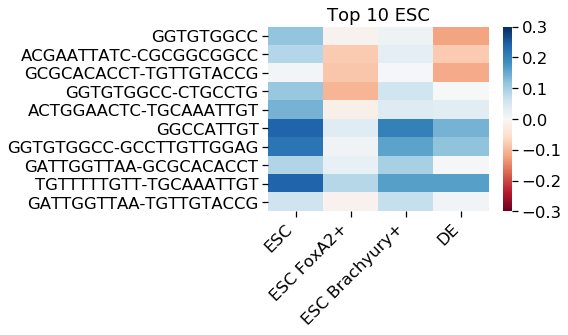

In [15]:
es_ind = conditions.index('es')
ed_ind = conditions.index('ed')
for j,condition in enumerate(conditions):
    if condition != 'es':
        allsorted = np.argsort((param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]-param_kmers_values[es_ind*len(kmers):(es_ind*len(kmers)+len(kmers))]))[::-1]
    else:
        allsorted = np.argsort((param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]-param_kmers_values[ed_ind*len(kmers):(ed_ind*len(kmers)+len(kmers))]))[::-1]

    top = allsorted[param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))][allsorted]>0][:10]
    for t in top:
        print(kmers[t])
    data = np.zeros((len(top),len(conditions)))
    for oj,oth in enumerate(conditions):
        for ti,t in enumerate(top):
            data[ti,oj] = param_kmers_values[oj*len(kmers)+t]
    data_df = pd.DataFrame(data=data,
                           columns=condition_names,
                           index=[kmers[t] for t in top])
    data_df = data_df[condition_order]
    plt.figure(figsize=(8,5))
    sns.heatmap(data_df,cmap='RdBu',vmin=-0.3, vmax=0.3)
    plt.xticks(rotation=45,ha='right')
    plt.title('Top 10 '+conditions2clean[condition])
    plt.tight_layout()
    plt.savefig('plots/differential_kmers_heatmap_'+condition+'.svg')
    plt.show()

In [16]:
seq_kmer = pd.read_csv('../libraryv3_analysis/libraryv3-100mer.csv')

In [24]:
kmers.index('CGCGGCGGCC')

40

In [25]:
print(conditions)

results.conf_int()[len(replicates)+40,:]

['foxa2', 'brachyury', 'ed', 'es']


array([-0.14047254, -0.01654503])

GGTGTGGCC-CTGCCTG
CGCGGCGGCC
ACGAATTATC-CGCGGCGGCC
ACTGGAACTC-TGCAAATTGT
GGTGTGGCC
ATGTTTAC-CGCGGCGGCC
ACTGGAACTC
GCGCACACCT-TGTTGTACCG
GTCACCTGAG-CGCGGCGGCC
GATTGGTTAA-TGTTGTACCG


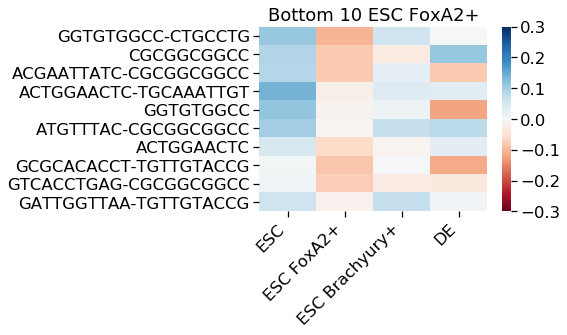

CAGCTGTG
CGCGGCGGCC
ACTGGAACTC
GTCACCTGAG-CGCGGCGGCC
ACTCTGT
CCTCCGCACC-GAACAGGTGC
GCGCACACCT
CCTCCGCACC
TCCAGTTCCA
CACCAGGGG


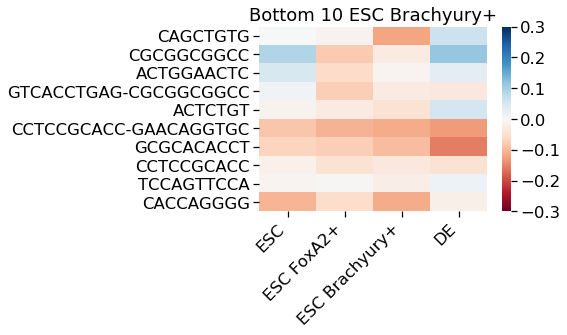

GGTGTGGCC
ACGAATTATC-CGCGGCGGCC
GCGCACACCT-TGTTGTACCG
ATACCGATAC-GCGCACACCT
GCGCACACCT
GTCACCTGAG-CGCGGCGGCC
CCTCCGCACC-GAACAGGTGC
CCTCCGCACC-GTAGGTGTTC
CGCACACCTG
CCTCCGCACC


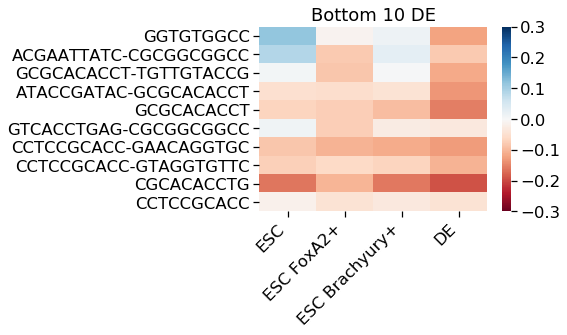

GTGACCACTG
GAGTGACACT-TGTCAACATT
ATGTTTAC-GTGACCACTG
TGCAGTGACA-TGGAGTGACA
TGTCAACATT
TGATGTCACT-TGGAGTGACA
GAGTGACACT
ATGTTTAC
TGGAGTGACA
GTCACCTGAG-GTGACCACTG


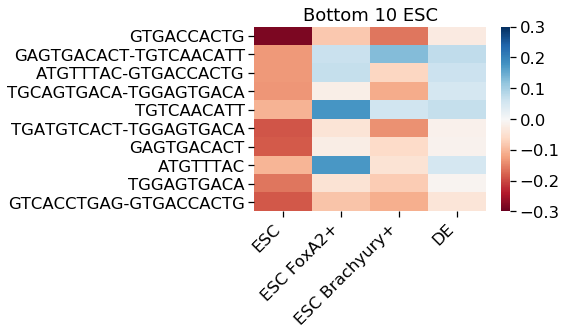

In [18]:
es_ind = conditions.index('es')
ed_ind = conditions.index('ed')
for j,condition in enumerate(conditions):
    if condition != 'es':
        allsorted = np.argsort((-param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]+param_kmers_values[es_ind*len(kmers):(es_ind*len(kmers)+len(kmers))]))[::-1]
    else:
        allsorted = np.argsort((-param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))]+param_kmers_values[ed_ind*len(kmers):(ed_ind*len(kmers)+len(kmers))]))[::-1]

    top = allsorted[param_kmers_values[j*len(kmers):(j*len(kmers)+len(kmers))][allsorted]<0][:10]
    for t in top:
        print(kmers[t])
    data = np.zeros((len(top),len(conditions)))
    for oj,oth in enumerate(conditions):
        for ti,t in enumerate(top):
            data[ti,oj] = param_kmers_values[oj*len(kmers)+t]
    data_df = pd.DataFrame(data=data,
                           columns=condition_names,
                           index=[kmers[t] for t in top])
    data_df = data_df[condition_order]
    plt.figure(figsize=(8,5))
    bottom_kmers = list(data_df.index)
    seqs = seq_kmer[seq_kmer['kmer'].isin(bottom_kmers)].seq
    backgrounds = np.random.permutation(seq_kmer[~(seq_kmer['kmer'].isin(bottom_kmers+['None',None]))].seq)[:len(seqs)]
    
    with open(condition+'_pos.fa','w') as f:
        for seq in seqs:
            f.write('>seq\n'+seq+'\n')
    with open(condition+'_neg.fa','w') as f:
        for seq in backgrounds:
            f.write('>seq\n'+seq+'\n')
            
    #subprocess.call(['/data/cgs/jhammelm/software/HOMER/bin/findMotifs.pl '+condition+'_pos.fa fasta '+condition+"-bottom_homer -fasta "+condition+'_neg.fa'],shell=True)
    sns.heatmap(data_df,cmap='RdBu',vmin=-0.3, vmax=0.3)
    plt.title('Bottom 10 '+conditions2clean[condition])
    plt.xticks(rotation=45,ha='right')
    plt.tight_layout()
    plt.savefig('plots/differential_closing_kmers_heatmap_'+condition+'.svg')
    plt.show()

In [ ]:
'''
FoxA2 Top 5
CCAGCACCCA
TGTCAACATT
ATGTTTAC
TCTGTGTGTGT
TGATGTCACT
'''

In [ ]:
'''
Brachyury Top 4
GAGTGACACT
TCTGTGTGTGT
TGTCAACATT
ATGTAAACAT
'''

In [ ]:
foxa2_kmers = ['CCAGCACCCA',
'TGTCAACATT',
'ATGTTTAC',
'TCTGTGTGTGT',
'TGATGTCACT',
'ATGTAAACAT'
 'ATACCGATAC']
def kmer_in(k):
    for fk in foxa2_kmers:
        if fk in k:
            return True
kmers_keep = [k for k in kmers if kmer_in(k)]
small_df = big_df.reindex(kmers_keep)
g = sns.clustermap(small_df,cmap='RdBu',figsize=(10,14),vmin=-0.3, vmax=0.3)
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 30)
plt.tight_layout()
plt.savefig('plots/foxa2_motif_combinations.svg')

In [ ]:
'''
FoxA2 / DE motif pair
TGGAGTGACA
TGCAGTGACA
TGTCACCTGA
'''

In [ ]:
foxa2_kmers = [
    'TGGAGTGACA',
'TGCAGTGACA',
'TGTCACCTGA',
'TGATGTCACT']
def kmer_in(k):
    for fk in foxa2_kmers:
        if fk in k:
            return True
kmers_keep = [k for k in kmers if kmer_in(k)]
small_df = big_df.reindex(kmers_keep)
g = sns.clustermap(small_df,cmap='RdBu',figsize=(10,15),vmin=-0.3, vmax=0.3)
plt.tight_layout()
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 30)
plt.show()